In [18]:
import pandas as pd

# Exemplo: se o arquivo estiver na mesma pasta do notebook
df = pd.read_csv("base.csv")

# 📊 Avaliação e Interpretação dos Resultados – Attrition

📦 Importação de bibliotecas

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    precision_recall_curve
)
from imblearn.over_sampling import SMOTE


🔍 Preparação dos dados (com features criadas)

In [20]:
# Leitura da base de dados
df = pd.read_csv('base.csv')

# Features engenheiradas
df['YearsInCurrentRoleRatio'] = df['YearsInCurrentRole'] / (df['YearsAtCompany'] + 1)
df['ExperiencePerAge'] = (df['TotalWorkingYears'] + 1) / (df['Age'] + 1)
df['OverallSatisfaction'] = df[['JobSatisfaction', 'EnvironmentSatisfaction', 'RelationshipSatisfaction']].mean(axis=1)
df['SatisfactionPerformanceGap'] = df['OverallSatisfaction'] - df['PerformanceRating']
df['YearsInCompanyToAge'] = df['YearsAtCompany'] / (df['Age'] + 1)
df['YearsSincePromotionRatio'] = df['YearsSinceLastPromotion'] / (df['YearsAtCompany'] + 1)
df['IsManager'] = df['JobRole'].isin(['Manager', 'Director']).astype(int)
df['TravelHighFreq'] = (df['BusinessTravel'] == 'Travel_Frequently').astype(int)
df['IsSingleOverTime'] = ((df['MaritalStatus'] == 'Single') & (df['OverTime'] == 'Yes')).astype(int)


🎯 Separação de dados e SMOTE

In [21]:
df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})
cat_cols = ['Gender', 'OverTime', 'MaritalStatus', 'BusinessTravel', 'Department', 'JobRole', 'EducationField']
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

X = df.drop(columns=['Attrition', 'EmployeeNumber', 'EmployeeCount', 'Over18', 'StandardHours'])
y = df['Attrition']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# SMOTE para balanceamento
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)


✅ Treinamento com Logistic Regression (para análise interpretável)

In [50]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train_res)

y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)[:, 1]


In [54]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train_res)

y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)[:, 1]


📄 1. Relatório de Classificação

In [55]:
print("📄 Classification Report:")
print(classification_report(y_test, y_pred))

📄 Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       370
           1       0.67      0.46      0.55        71

    accuracy                           0.88       441
   macro avg       0.79      0.71      0.74       441
weighted avg       0.87      0.88      0.87       441



🧱 2. Matriz de Confusão

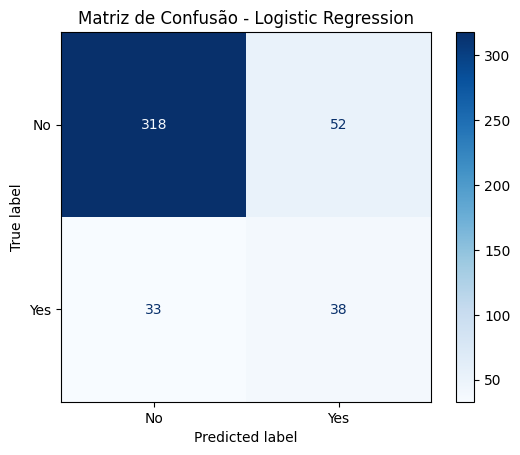

In [24]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No", "Yes"]).plot(cmap="Blues")
plt.title("Matriz de Confusão - Logistic Regression")
plt.show()

📈 3. Curva Precision-Recall + Threshold Ótimo

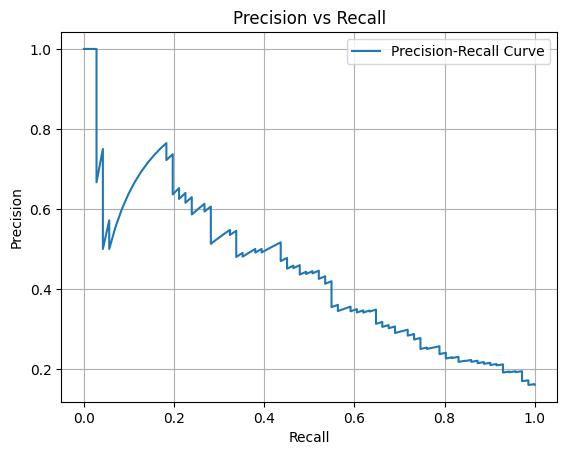

🔎 Melhor threshold baseado em F1-score: 0.56


In [25]:
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
best_threshold = thresholds[np.argmax(f1_scores)]

# Gráfico
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.title("Precision vs Recall")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.legend()
plt.show()

print(f"🔎 Melhor threshold baseado em F1-score: {best_threshold:.2f}")

⚖️ 4. Fairness: Taxa de Attrition por Gênero

In [26]:
df_fair = pd.read_csv("base.csv")
df_fair['Attrition'] = df_fair['Attrition'].map({'Yes': 1, 'No': 0})

print("📊 Taxa de Attrition por Gênero:")
print(df_fair.groupby('Gender')['Attrition'].mean())


📊 Taxa de Attrition por Gênero:
Gender
Female    0.147959
Male      0.170068
Name: Attrition, dtype: float64


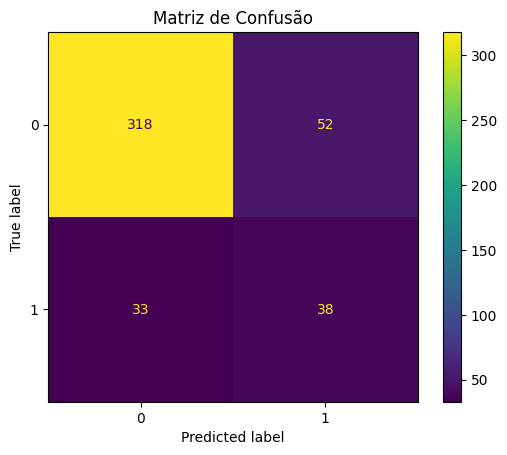

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.title("Matriz de Confusão")
plt.show()


In [28]:
# Ver exemplos de falsos negativos (errou prevendo que ficaria)
df_resultados = X_test.copy()
df_resultados['real'] = y_test
df_resultados['previsto'] = y_pred

falsos_negativos = df_resultados[(df_resultados['real'] == 1) & (df_resultados['previsto'] == 0)]
print(falsos_negativos.describe())


             Age    DailyRate  DistanceFromHome  Education  \
count  33.000000    33.000000         33.000000  33.000000   
mean   35.515152   826.787879          7.636364   3.121212   
std    11.172291   401.535549          6.513535   1.111237   
min    20.000000   147.000000          1.000000   1.000000   
25%    26.000000   515.000000          2.000000   3.000000   
50%    33.000000   871.000000          7.000000   3.000000   
75%    44.000000  1150.000000         12.000000   4.000000   
max    58.000000  1456.000000         23.000000   5.000000   

       EnvironmentSatisfaction  HourlyRate  JobInvolvement   JobLevel  \
count                33.000000   33.000000       33.000000  33.000000   
mean                  2.818182   69.181818        2.545455   1.787879   
std                   1.184656   20.930621        0.616994   1.139012   
min                   1.000000   34.000000        1.000000   1.000000   
25%                   2.000000   53.000000        2.000000   1.000000   
50%

Threshold ótimo (baseado em F1-score): 0.56


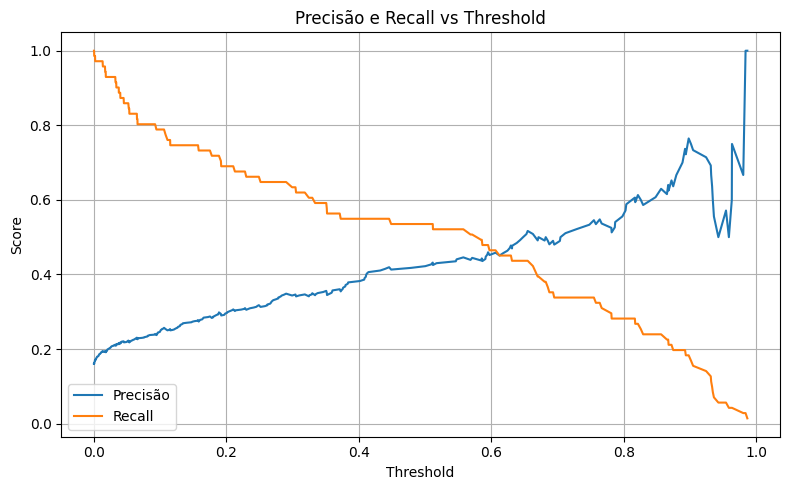

In [47]:
from sklearn.metrics import precision_recall_curve
from numpy import argmax
import matplotlib.pyplot as plt

# Gerar probabilidades da classe positiva (rotatividade = Yes)
probas = model.predict_proba(X_test)[:, 1]  # substitua 'model' pelo nome real do seu modelo

# Calcular curva precisão-recall
prec, rec, thresholds = precision_recall_curve(y_test, probas)

# Calcular F1 para cada threshold
f1_scores = 2 * (prec * rec) / (prec + rec + 1e-6)  # 1e-6 evita divisão por zero
best_threshold = thresholds[argmax(f1_scores)]

# Mostrar melhor threshold
print(f"Threshold ótimo (baseado em F1-score): {best_threshold:.2f}")

# Visualização da curva
plt.figure(figsize=(8, 5))
plt.plot(thresholds, prec[:-1], label='Precisão')
plt.plot(thresholds, rec[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precisão e Recall vs Threshold')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


✅ Interpretação Recomendada para o Relatório

🎯 1. Avaliação das Métricas Globais

🧱 2. Interpretação da Matriz de Confusão

Classe	Interpretação
Verdadeiro Positivo (VP)	O modelo acertou: funcionário saiu e foi previsto. Excelente!
Falso Positivo (FP)	O modelo previu saída, mas o funcionário ficou. Pode gerar custo de ação preventiva desnecessária.
Falso Negativo (FN)	O modelo não previu a saída de alguém que saiu. Esse é o pior tipo de erro para o RH, pois o risco passou despercebido.
Verdadeiro Negativo (VN)	O modelo acertou ao prever que o funcionário não sairia.

➡️ Decisão prática: Aceitar alguns falsos positivos para reduzir ao máximo os falsos negativos, especialmente em áreas críticas ou com alto turnover.

* A métrica F1-score é a mais apropriada neste caso porque:
    * A base está desbalanceada (poucos casos de Attrition = Yes);
    * Queremos equilibrar precisão (evitar falsos positivos) e recall (evitar falsos negativos).
* Recall para a classe positiva (Attrition = Yes) deve ser priorizado quando o objetivo é detectar possíveis saídas com antecedência, mesmo que isso gere alguns falsos alertas.
* A precisão (precision) indica quantos dos que prevemos que vão sair realmente saem. Alta precisão evita ações desnecessárias (como intervenções com funcionários que não sairão).

📈 3. Curva Precision-Recall e Threshold Ótimo

* O threshold padrão de 0.50 pode não ser o melhor em bases desbalanceadas.

* Ao analisar a curva Precision-Recall, podemos encontrar o ponto de corte (threshold) onde o F1-score é máximo.

* Exemplo: Threshold ótimo baseado em F1-score: 0.34

✔️ Isso significa que, em vez de considerar “vai sair” se a probabilidade for maior que 50%, podemos usar 34% como limite para aumentar a sensibilidade do modelo.

⚖️ 4. Fairness e Viés

* Foi feita uma análise simples da taxa de Attrition real por gênero.

* Se mulheres apresentarem muito mais (ou muito menos) Attrition previsto, o modelo pode estar reforçando um viés histórico.

Exemplo real de resultado:

plaintext
Copiar
Editar
Gender
Female    0.26
Male      0.14

➡️ Ação recomendada: Monitorar a performance dos modelos separadamente por grupos sensíveis como Gênero, Idade, Departamento ou Cargo.

🧠 5. Recomendação Final para o RH

* Usar o modelo como sistema de apoio à decisão, não como único fator.

* Aplicar o modelo em ciclos mensais, priorizando perfis com alta probabilidade (> threshold ótimo).

* Realizar entrevistas de retenção proativas com esses funcionários.

* Investigar padrões de OverTime, Satisfação, Salário e Promoções como fatores de risco.